In [287]:
%matplotlib inline

from collections import Counter
from collections import defaultdict
import functools
import glob
import itertools
from itertools import izip
import os

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
from matplotlib_venn import venn2, venn3
import pybedtools
import numpy as np
from IPython.core.display import HTML
import pandas as pd
import matplotlib as mpl

from gscripts import GO
from gscripts.rnaseq import splicing_map
from gscripts.general import dataviz
from gscripts.general import region_helpers

In [288]:
legend = None

OUTSIDE_LEGEND_SAVEFIG_KWS = dict(bbox_extra_artists=(legend,),
                                  bbox_inches='tight')
from matplotlib import rc

mpl.rcParams['svg.fonttype'] = 'none'

rc('text', usetex=False) 
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

In [276]:
names = {'hWT': 'WT/GT-hWT',
         'gt': 'WT/GT',
         'rev': 'WT/WT',
         "q331k": 'WT/GT-Q331K'}

In [25]:
class ArrayJob():
    def __init__(self):
        self._epilogue = "eval ${cmd[$PBS_ARRAYID]}"

    def _prologue(self, name, count, run_dir, ppn=1, walltime=8):
        return """#!/bin/bash
#PBS -N {0}
#PBS -l nodes=1:ppn={3}
#PBS -o {0}.out
#PBS -e {0}.err
#PBS -V
#PBS -q home-yeo
#PBS -W group_list=yeo-group
#PBS -t 1-{1}
#PBS -l walltime={4}:00:00
cd {2}
echo "hello, starting"

""".format(os.path.basename(name), count, run_dir, ppn, walltime)

        
    def make_script(self, commands, script_name, run_dir, ppn=1, walltime=8):
        total = 0 
        result = []
        num_out = 0
        for cmd in commands:
            total += 1
            result.append('cmd[{}]="{}"'.format(total, cmd))
            if total >= 500:
                with open("{}_{}.sh".format(script_name, num_out), 'w') as out_file:
                    out_file.write(self._prologue("{}_{}".format(script_name, num_out), total, run_dir, ppn, walltime ))
                    for line in result:
                        out_file.write(line + "\n\n")
                    out_file.write(self._epilogue + "\n")
                total = 0 
                num_out += 1
                result = []

        with open("{}_{}.sh".format(script_name, num_out), 'w') as out_file:
            out_file.write(self._prologue("{}_{}".format(script_name, num_out), total, run_dir, ppn, walltime))
            for line in result:
                out_file.write(line + "\n\n")
            out_file.write(self._epilogue + "\n")

In [3]:
job_maker = ArrayJob()

In [ ]:
#Old rMATS version
/home/yeo-lab/software/rMATS.3.2.4/RNASeq-MATS.py

In [14]:
def make_miso_submitter(bam, cell_type):
    id_name = bam.split(".")[0]
    bam_loc = os.path.join("/home/elvannostrand/scratch/ENCODE_rnaseq/bam_files_shashank/", cell_type, bam + ".sorted.bam")
    return "submit_miso_pipeline.py  '--bam' '{0}'  '--sample-id' '{1}'  '--genome' 'hg19'  '--do-not-submit'  '--output-sh' '{1}.miso.sh'  &&  'sh' '{1}.miso.sh'  &&  'touch' '/home/gpratt/projects/encode/analysis/miso_out/{1}.miso'".format(bam_loc, id_name) 

def run_rmats(b1, b2, b1_mean, b2_mean, b1_std, b2_std, read_len, gtf, out_dir):
    b1 = ",".join(b1)
    b2 = ",".join(b2)
    b1_mean = ",".join(b1_mean)
    b2_mean = ",".join(b2_mean)
    b1_std = ",".join(b1_std)
    b2_std = ",".join(b2_std)

    return "python /home/gpratt/software/rMATS.3.2.5/RNASeq-MATS.py -b1 {0} -b2 {1} -r1 {2} -r2 {3} -sd1 {4} -sd2 {5} -gtf {6} -t paired -len {7} -a 8 -o {8} -novelSS 1".format(b1, b2, b1_mean, b2_mean, b1_std, b2_std, gtf, read_len, out_dir)

def collect_insert_size_metrics(bam, out_dir):
    
    name = os.path.basename(bam).split(".")[0]
    out_txt = os.path.join(out_dir, name) + ".txt"
    out_pdf = os.path.join(out_dir, name) + ".pdf"

    if os.path.exists(out_txt):
       return None

    return "java -jar /home/yeo-lab/software/picard-tools-1.141/picard.jar CollectInsertSizeMetrics I={} O={} H={} VALIDATION_STRINGENCY=SILENT".format(bam, out_txt, out_pdf)

def parse_insert_size_metrics(CollectInsertSizeMetricsFile):
    try:
        with open(CollectInsertSizeMetricsFile) as metrics_file:
            metrics_file.next()
            metrics_file.next()
            metrics_file.next()
            metrics_file.next()
            metrics_file.next()
            metrics_file.next()
            header = metrics_file.next().split()
            data = metrics_file.next().split()
            return pd.Series({key: value for key, value in zip(header, data)})
    except Exception as e:
        print "error", os.path.basename(CollectInsertSizeMetricsFile)
        raise e

In [15]:
bam_files = glob.glob("/projects/ps-yeolab3/from_hotel_node/for_anthony/analysis/av_mouse_stress_v4/*.rg.bam")
insert_size_metrics = [collect_insert_size_metrics(bam_file, "/projects/ps-yeolab3/from_hotel_node/for_anthony/analysis/insert_sizes") for bam_file in bam_files]


In [6]:
for x in insert_size_metrics:
    !$x

/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found
/bin/sh: None: command not found


In [16]:
metadata = pd.read_csv("/home/gpratt/Dropbox/cryptic_splicing/data/mouse_data/SampleInfo.csv", index_col=0)

In [17]:
def make_size_metrics(row, bam_column):
    return os.path.join("/projects/ps-yeolab3/from_hotel_node/for_anthony/analysis/insert_sizes", os.path.basename(row[bam_column]).split(".")[0] + ".txt")

mn_metrics = functools.partial(make_size_metrics, bam_column="sample_id.1")
metadata['bam_size'] = metadata.apply(mn_metrics, axis=1)

In [18]:
bam_dir = "/projects/ps-yeolab3/from_hotel_node/for_anthony/analysis/av_mouse_stress_v4/"

In [19]:
metadata['bam_file'] = metadata['sample_id.1'].apply(lambda x: bam_dir + x + ".sorted.rg.bam")

In [20]:
june_metadata = metadata[(metadata.date == "june")]

june_metadata_stressed = metadata[(metadata.date == "june") & (metadata.stress == True)]
june_metadata_unstressed = metadata[(metadata.date == "june") & (metadata.stress == False)]


In [21]:
comparisons = [("q331k", "rev"),
 ("q331k", "hWT"),
 ("q331k", "gt"),
 ("hWT" ,"gt"), 
 ("hWT", "rev"),
 ("gt", "rev"),]


In [22]:
results = []
for kd, ctrl in comparisons:
    kd_df = june_metadata_stressed[june_metadata_stressed.genotype == kd]
    ctrl_df = june_metadata_stressed[june_metadata_stressed.genotype == ctrl]
    out_dir="/home/gpratt/projects/for_anthony/analysis/rMATS/{}_vs_{}_stressed".format(kd, ctrl)

    
    kd_stats = pd.concat({"rep1": parse_insert_size_metrics(kd_df.iloc[0].bam_size), 
                          "rep2": parse_insert_size_metrics(kd_df.iloc[1].bam_size)}).unstack()

    ctrl_stats = pd.concat({"rep1": parse_insert_size_metrics(ctrl_df.iloc[0].bam_size), 
                            "rep2": parse_insert_size_metrics(ctrl_df.iloc[1].bam_size)}).unstack()
    

    results.append(run_rmats([kd_df.iloc[0].bam_file, kd_df.iloc[1].bam_file],
                                 [ctrl_df.iloc[0].bam_file, ctrl_df.iloc[1].bam_file],
                                 kd_stats.MEAN_INSERT_SIZE, 
                                 ctrl_stats.MEAN_INSERT_SIZE, 
                                 kd_stats.STANDARD_DEVIATION,  
                                 ctrl_stats.STANDARD_DEVIATION,
                                 read_len = 55,
                                 gtf="/projects/ps-yeolab/genomes/mm10/gencode/gencode.vM3.annotation.gtf",
                                 out_dir=out_dir))
for kd, ctrl in comparisons:
    kd_df = june_metadata_unstressed[june_metadata_unstressed.genotype == kd]
    ctrl_df = june_metadata_unstressed[june_metadata_unstressed.genotype == ctrl]
    out_dir="/home/gpratt/projects/for_anthony/analysis/rMATS/{}_vs_{}_unstressed".format(kd, ctrl)
    
    kd_stats = pd.concat({"rep1": parse_insert_size_metrics(kd_df.iloc[0].bam_size), 
                          "rep2": parse_insert_size_metrics(kd_df.iloc[1].bam_size)}).unstack()

    ctrl_stats = pd.concat({"rep1": parse_insert_size_metrics(ctrl_df.iloc[0].bam_size), 
                            "rep2": parse_insert_size_metrics(ctrl_df.iloc[1].bam_size)}).unstack()
    

    results.append(run_rmats([kd_df.iloc[0].bam_file, kd_df.iloc[1].bam_file],
                                 [ctrl_df.iloc[0].bam_file, ctrl_df.iloc[1].bam_file],
                                 kd_stats.MEAN_INSERT_SIZE, 
                                 ctrl_stats.MEAN_INSERT_SIZE, 
                                 kd_stats.STANDARD_DEVIATION,  
                                 ctrl_stats.STANDARD_DEVIATION,
                                 read_len = 55,
                                 gtf="/projects/ps-yeolab/genomes/mm10/gencode/gencode.vM3.annotation.gtf",
                                 out_dir=out_dir))

for genotype, df in june_metadata.groupby("genotype"):
    (foo, ctrl_df), (bar, kd_df) = list(df.groupby("stress"))
    if not bar or foo:
        print "error"
        
        
    out_dir="/home/gpratt/projects/for_anthony/analysis/rMATS/{}_stressed_vs_unstressed".format(genotype)
    
    kd_stats = pd.concat({"rep1": parse_insert_size_metrics(kd_df.iloc[0].bam_size), 
                          "rep2": parse_insert_size_metrics(kd_df.iloc[1].bam_size)}).unstack()

    ctrl_stats = pd.concat({"rep1": parse_insert_size_metrics(ctrl_df.iloc[0].bam_size), 
                            "rep2": parse_insert_size_metrics(ctrl_df.iloc[1].bam_size)}).unstack()
    

    results.append(run_rmats([kd_df.iloc[0].bam_file, kd_df.iloc[1].bam_file],
                                 [ctrl_df.iloc[0].bam_file, ctrl_df.iloc[1].bam_file],
                                 kd_stats.MEAN_INSERT_SIZE, 
                                 ctrl_stats.MEAN_INSERT_SIZE, 
                                 kd_stats.STANDARD_DEVIATION,  
                                 ctrl_stats.STANDARD_DEVIATION,
                                 read_len = 55,
                                 gtf="/projects/ps-yeolab/genomes/mm10/gencode/gencode.vM3.annotation.gtf",
                                 out_dir=out_dir))

In [23]:
job_maker.make_script(results, script_name="/home/gpratt/projects/for_anthony/scripts/rMATS", 
                     run_dir="/home/gpratt/projects/for_anthony/analysis/rMATS/",
                     ppn=8,
                     walltime=48)

# Analysis 

In [197]:
def parse_rMATS(fn):
    """Given a file name parses it but also uses rMATS file structure to find cryptic events, infer them and returns the entire thing"""
    df = pd.read_table(fn, index_col=0)
    splice_type = os.path.basename(fn).split(".")[0]
    dir_name = os.path.split(os.path.split(fn)[0])[0]
    
    normal =  pd.read_table(os.path.join(dir_name, "ASEvents", "fromGTF.{}.txt").format(splice_type), index_col=0)
    cryptic = pd.read_table(os.path.join(dir_name, "ASEvents", "fromGTF.novelEvents.{}.txt").format(splice_type), index_col=0)
    normal["is_cryptic"] = normal.index.isin(cryptic.index)
    normal = normal.drop(set(normal.columns).difference(set(["is_cryptic"])), axis=1)
    df = df.join(normal)
    return df

#I have to resort to this iterator stragety to keep my memory footprint low
#this takes all merged events and returns a group_id (count) and all the samples that have the event, along with the event itself (value)
def events_dict_iter(grouped_events):
    for count, (key, value) in enumerate(grouped_events.iteritems()):
        yield count, value

#This takes all the actual events and makes a maping of group_id to the original dataframe id
def real_results_iter(grouped_events, min_key):
    for key, value in events_dict_iter(grouped_events):
        for item in value:
            yield item, key + min_key

def annotate_events(events, grouped_df, min_key):
    """takes a grouped dataframe and returns annotated events"""
    real_results_df = pd.DataFrame(pd.Series(dict(real_results_iter(grouped_df.groups, min_key)), name="group_id"))
    #Assign that value back to the full ist of event annotations
    annotated_combined_events = pd.concat([events, real_results_df], axis=1)
    return annotated_combined_events

def annotate_se_events(se_events, min_key):
    #Group events by location
    df = se_events.groupby(["chr", "strand", "downstreamEE", "downstreamES", "upstreamEE", "upstreamES", "exonEnd", "exonStart_0base"])
    return annotate_events(se_events, df, min_key)

def annotate_mxe_events(se_events, min_key):

    #Group events by location
    df = se_events.groupby(["chr", "strand",  "1stExonStart_0base", "1stExonEnd", "2ndExonStart_0base", "2ndExonEnd", "upstreamES", "upstreamEE", "downstreamES", "downstreamEE"])
    return annotate_events(se_events, df, min_key)

def annotate_a5ss_events(se_events, min_key):

    #Group events by location
    df = se_events.groupby(["chr", "strand", "longExonStart_0base", "longExonEnd", "shortES", "shortEE", "flankingES", "flankingEE"])
    return annotate_events(se_events, df, min_key)

def annotate_a3ss_events(se_events, min_key):

    #Group events by location
    df = se_events.groupby(["chr", "strand", "longExonStart_0base", "longExonEnd", "shortES", "shortEE", "flankingES", "flankingEE"])
    return annotate_events(se_events, df, min_key)

def annotate_ri_events(se_events, min_key):

    #Group events by location
    df = se_events.groupby(["chr", "strand", "riExonStart_0base", "riExonEnd", "upstreamES", "upstreamEE", "downstreamES", "downstreamEE"])
    return annotate_events(se_events, df, min_key)

def get_rMATS_events(events_list):
    #might want to eventually convert that into an events list
    df = pd.DataFrame(pd.Series({os.path.basename(item): item for item in events_list}, name="events"))
    
    df['SE'] = df.events.apply(lambda x: os.path.join(x, "MATS_output", "SE.MATS.JunctionCountOnly.txt"))
    df['MXE'] = df.events.apply(lambda x: os.path.join(x, "MATS_output", "MXE.MATS.JunctionCountOnly.txt"))
    df['A5SS'] = df.events.apply(lambda x: os.path.join(x, "MATS_output", "A5SS.MATS.JunctionCountOnly.txt"))
    df['A3SS'] = df.events.apply(lambda x: os.path.join(x, "MATS_output", "A3SS.MATS.JunctionCountOnly.txt"))
    df['RI'] = df.events.apply(lambda x: os.path.join(x, "MATS_output", "RI.MATS.JunctionCountOnly.txt"))
    
    print "paths that didn't exist", df[~df['SE'].apply(os.path.exists)].values
    df = df[df['SE'].apply(os.path.exists)]
    
    se = pd.concat({key: parse_rMATS(value) for key, value in df.SE.iteritems()}, names=["condition", "event_id"])
    se = annotate_se_events(se, 0)
    max_index = max(se.group_id)
    
    mxe = pd.concat({key: parse_rMATS(value) for key, value in df.MXE.iteritems()}, names=["condition", "event_id"])
    mxe = annotate_mxe_events(mxe, max_index + 1)
    max_index = max(mxe.group_id)

    a5ss = pd.concat({key: parse_rMATS(value) for key, value in df.A5SS.iteritems()}, names=["condition", "event_id"])
    a5ss = annotate_a5ss_events(a5ss, max_index + 1)
    max_index = max(a5ss.group_id)

    a3ss = pd.concat({key: parse_rMATS(value) for key, value in df.A3SS.iteritems()}, names=["condition", "event_id"])
    a3ss = annotate_a3ss_events(a3ss, max_index + 1)
    max_index = max(a3ss.group_id)

    ri = pd.concat({key: parse_rMATS(value) for key, value in df.RI.iteritems()}, names=["condition", "event_id"])
    ri = annotate_ri_events(ri, max_index + 1)

    #return se, mxe, a5ss, a3ss, ri

    all_events = pd.concat({"SE": se,
                            "MXE": mxe,
                            "A5SS": a5ss,
                            "A3SS": a3ss,
                            "RI": ri,
                                  }, 
                                  names=["event_type", "condition", "event_id"]
                                 )
    all_events = all_events.set_index(['group_id'], append=True)
    all_events.index = all_events.index.droplevel("event_id")
    return all_events

In [198]:
#THIS NEEDS LARGE AMOUNTS OF MEMORY, RUN WITH ppn=4 minium, will have to optomize very soon for scaling
mouse_stress_events = glob.glob("/home/gpratt/projects/for_anthony/analysis/rMATS/*")

all_events = get_rMATS_events(mouse_stress_events)

paths that didn't exist []


In [200]:
def get_significant_events(events):
    sig_events = events[events.FDR < .05]
    sig_events = sig_events[np.abs(sig_events.IncLevelDifference) > .1]
    sig_events = pd.concat({"excluded": sig_events[sig_events.IncLevelDifference < 0],
                            "included": sig_events[sig_events.IncLevelDifference > 0],}, 
                           names=["direction", "event_type", "condition", "group_id"])
    sig_events = sig_events.swaplevel(0,1)
    return sig_events

all_events['is_cryptic'] = all_events.is_cryptic.fillna(True)
all_annotated_events = all_events[~all_events.is_cryptic]

all_sig_events = get_significant_events(all_annotated_events)

In [259]:
all_sig_events = all_sig_events.swaplevel("event_type", "condition")

In [256]:
stress_vs_unstressed = ['gt_stressed_vs_unstressed', "hWT_stressed_vs_unstressed", 'q331k_stressed_vs_unstressed', 'rev_stressed_vs_unstressed']

genotype_comparisons = [u'gt_vs_rev_stressed',
                        u'gt_vs_rev_unstressed', 
                        u'hWT_vs_gt_stressed',
                        u'hWT_vs_gt_unstressed', 
                        u'hWT_vs_rev_stressed',
                        u'hWT_vs_rev_unstressed', 
       u'q331k_vs_gt_stressed', u'q331k_vs_gt_unstressed',
       u'q331k_vs_hWT_stressed', u'q331k_vs_hWT_unstressed',
       u'q331k_vs_rev_stressed', u'q331k_vs_rev_unstressed',]

In [260]:
stress_vs_unstressed_df = all_sig_events.ix[stress_vs_unstressed]
genotype_comparisons_df = all_sig_events.ix[genotype_comparisons]

In [266]:
item

(u'gt_vs_rev_stressed', 'excluded', 'A3SS', 154628)

In [269]:
new_index = []
for item in genotype_comparisons_df.index:
    genotype_1, vs, genotype_2, condition = item[0].split("_")
    new_index.append([genotype_1, genotype_2, condition, item[1], item[2], item[3]])

genotype_comparisons_df.index = pd.MultiIndex.from_tuples(new_index, names=['genotype_1', 'genotype_2', 'condition', 'direction', 'event_type', 'group_id'])

In [296]:
genotype_comparisons_df.groupby(level=["genotype_1", "genotype_2", "condition", "direction"]).count().FDR.mean()

225.41666666666666

In [298]:
(13 + 2 + 17 + 0) / 4

8

# How Many events are there in total?

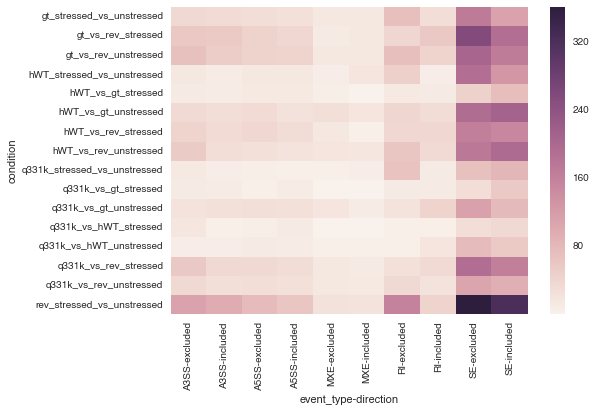

In [233]:
all_sig_events_counts = all_sig_events.groupby(level=["event_type", "direction", "condition"]).count().FDR.unstack()
sns.heatmap(all_sig_events_counts.T)

# How about a rough check of the number of shared events?

In [240]:
shared_events = all_sig_events.groupby(level="group_id").count().FDR 
print "num shared events", len(shared_events[shared_events > 1])

num shared events 2087


In [241]:
shared_events = all_sig_events.groupby(level=["event_type", "group_id"]).count().FDR 
print "num shared events", len(shared_events[shared_events > 1])


num shared events 2087


In [242]:
shared_events = all_sig_events.groupby(level=["event_type", "direction", "group_id"]).count().FDR 
shared_events = shared_events[shared_events > 1]

In [243]:
len(shared_events)

1717

In [244]:
shared_events = all_sig_events.groupby(level=["event_type", "direction", "group_id"]).count().FDR 
shared_events = shared_events[shared_events > 1]

In [245]:
shared_events.groupby(level=["event_type", "direction"]).count().unstack()

direction,excluded,included
event_type,,
A3SS,121,90
A5SS,79,77
MXE,52,33
RI,172,99
SE,544,450


# Break up the data to stress vs no stress and Q331K comparisons to everything else

# Lets plot some venns
I'll start by not even breaking down SE vs everything else, see how that goes.

In [274]:
img_dir = "/home/gpratt/Dropbox/mouse_stress/figures"

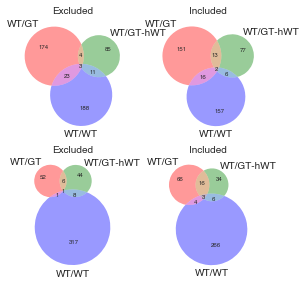

In [289]:
num_rows = 2
num_cols = 2
with dataviz.Figure(os.path.join(img_dir, "splicing_unstressed_all_changes_rmats.svg"), figsize=(num_rows * 2, num_cols * 2)) as fig:
    ax = fig.add_subplot(num_cols, num_rows,1)
    venn = venn3([genotype_comparisons_df.ix['q331k', 'gt', 'unstressed', 'excluded'].index,
                  genotype_comparisons_df.ix['q331k', 'hWT', 'unstressed', 'excluded'].index,
                  genotype_comparisons_df.ix['q331k', 'rev', 'unstressed', 'excluded'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Excluded", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(num_cols,num_rows,2)
    venn = venn3([genotype_comparisons_df.ix['q331k', 'gt', 'unstressed', 'included'].index,
                  genotype_comparisons_df.ix['q331k', 'hWT', 'unstressed', 'included'].index,
                  genotype_comparisons_df.ix['q331k', 'rev', 'unstressed', 'included'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Included", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(num_cols, num_rows,3)
    venn = venn3([genotype_comparisons_df.ix['q331k', 'gt', 'stressed', 'excluded'].index,
                  genotype_comparisons_df.ix['q331k', 'hWT', 'stressed', 'excluded'].index,
                  genotype_comparisons_df.ix['q331k', 'rev', 'stressed', 'excluded'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Excluded", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
    
    ax = fig.add_subplot(num_cols,num_rows,4)
    venn = venn3([genotype_comparisons_df.ix['q331k', 'gt', 'stressed', 'included'].index,
                  genotype_comparisons_df.ix['q331k', 'hWT', 'stressed', 'included'].index,
                  genotype_comparisons_df.ix['q331k', 'rev', 'stressed', 'included'].index,],
            set_labels=map(lambda x: names[x], ("gt", "hWT", "rev")), 
            #set_colors=(rbp_colors['spinalcord'], rbp_colors['straitum'], rbp_colors['wholebrain']), 
                 ax=ax)
    ax.set_title("Included", fontsize=10)
    [label.set_fontsize(6) for label in venn.subset_labels if label is not None]
    [label.set_fontsize(10) for label in venn.set_labels  if label is not None]
